In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd
import hydromt

from pathlib import Path
from hydromt_sfincs import SfincsModel
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# Define your custom colors for floodmaps
colors = ['grey', 'white', 'blue', 'lightblue']
cmap = ListedColormap(colors)
bounds = np.array([-1.5, -0.5, 0.5, 1.5, 2.5])
norm = BoundaryNorm(bounds, cmap.N)

We analyze the results in the following steps:
1. Load SFINCS models and read the results.
2. Load OPERA floodmaps, define timestamps, and define data mapping to match SFINCS.
3. Open and reproject OPERA flood maps, and preprocess to match your needs.
4. Compare SFINCS and OPERA floodmaps.

### 1. Load SFINCS models and read the results.
Load all models and results and add them to a dictionary:

In [3]:
model_names = os.listdir(Path("model"))
models = {}
results = {}

no_results = []
for model_name in model_names:
    model = SfincsModel(fr"model/{model_name}/", mode="r")
    model.read_results()

    if not any(model.results):
        no_results.append(model_name)
    else:
        # If we have results, we append the model for our analysis.
        models[model_name] = model
        results[model_name] = model.results

model_names = list(filter(lambda x: x not in no_results, model_names))
print("Models with results: ", model_names)
print("Models without results: ", no_results)

Models with results:  ['garissa_depth2m_fabdem_grid100', 'garissa_depth2m_fabdem_grid100_avg_buffer5km', 'garissa_depth2m_fabdem_grid100_avg_lin', 'garissa_depth2m_srtm30_grid100', 'garissa_depth3m_fabdem_grid100', 'garissa_depth4m_fabdem_grid100_avg', 'garissa_depth4m_srtm30_grid100_avg']
Models without results:  ['base', 'unused']


In [4]:
# We append 1 model as the base model, with a representative grid.
mod0 = models["garissa_depth3m_fabdem_grid100"]

### 2. Load OPERA floodmaps, define timestamps, and define data mapping to match SFINCS.
Load and plot the available flood maps:

In [5]:
# Available floodmaps
floodmap_dates = [
    "2023-10-12",
    "2023-11-11",
    "2023-11-21",
    "2023-11-26",
    "2023-11-29",
    "2023-12-01",
]
print(floodmap_dates)

['2023-10-12', '2023-11-11', '2023-11-21', '2023-11-26', '2023-11-29', '2023-12-01']


Define data mapping:

In [6]:
# Each dataset has its own defined conventions, so we need to pre-process the data
# clouds:-1, no water:0, permanent water:1, flood:2.
data_map = {
        "2023-10-12":{-4:1, 1:1},
        "2023-11-11":{-4:1, 1:1, -3:-1},
        "2023-11-21":{-4:1, 1:1, -3:-1},
        "2023-11-26":{-4:1, 1:1, -3:-1},
        "2023-11-29":{-3:-1, -1:-1, 1:1},
        "2023-12-01":{-4:1, 1:1, -3:-1},
}

def map_values(map, array):
    for i in range(array.data.shape[0]):
        for j in range(array.data.shape[1]):

            if array.data[i,j] in map.keys():
                array.data[i,j] = map[array.data[i,j]]
                
    return array

Add timestamps to data:

In [7]:
# Times at which floodmaps where created
floodmap_times = {
        "2023-10-12":np.datetime64("2023-10-12T07:28:31"),
        "2023-11-11":np.datetime64("2023-11-11T07:31:31"),
        "2023-11-21":np.datetime64("2023-11-21T07:32:11"),
        "2023-11-26":np.datetime64("2023-11-26T07:31:39"), 
        "2023-11-29":np.datetime64("2023-11-29T07:30:38"),
        "2023-12-01":np.datetime64("2023-12-01T07:32:41"),
    }

print(floodmap_times)

{'2023-10-12': numpy.datetime64('2023-10-12T07:28:31'), '2023-11-11': numpy.datetime64('2023-11-11T07:31:31'), '2023-11-21': numpy.datetime64('2023-11-21T07:32:11'), '2023-11-26': numpy.datetime64('2023-11-26T07:31:39'), '2023-11-29': numpy.datetime64('2023-11-29T07:30:38'), '2023-12-01': numpy.datetime64('2023-12-01T07:32:41')}


In [8]:
analysis_extent_path = Path(r"../data/2_floodmaps/analysis_extent_garissa.shp")
analysis_extent = gpd.read_file(analysis_extent_path)

### 3. Open and reproject OPERA flood maps, and preprocess to match your needs.

OPERA has a raster format. Firstly, we open and reproject the floodmaps.

In [9]:
floodmaps = {}

for date in floodmap_dates:
    path = Path(f"../data/2_floodmaps/opera/{date}/floodmap.tif")

    # First, we open the flood map and convert it to the datatype we want.
    floodmap = hydromt.open_raster(path).load().astype(np.int8)
    floodmap.raster.set_spatial_dims(x_dim="x", y_dim="y")
    floodmap = floodmap.raster.reproject_like(mod0.grid, method='nearest')

    # Now, we re-map the data to the wanted values.
    floodmap = map_values(data_map[date], floodmap)
    floodmaps[date] = floodmap

Secondly, we process the data to contain a permanent water mask.

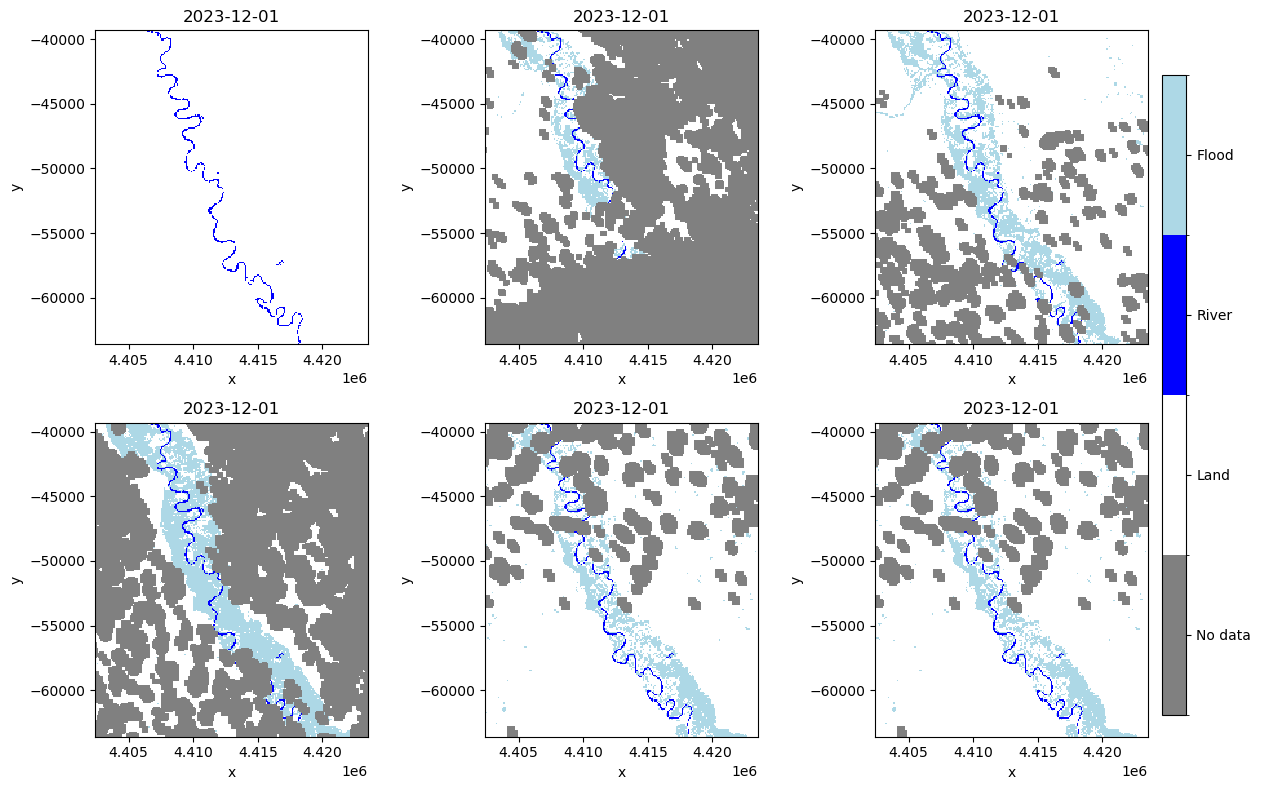

In [10]:
# We use the floodmap of 2023-10-12 as a reference.
ref_map = floodmaps["2023-10-12"]

fig, axs = plt.subplots(2,3, figsize=(12, 8))
axs=axs.ravel()
i= 0
for key, floodmap in floodmaps.items():
    # We convert each pixel to a corresponding flood or permanent water mask.
    mask = (floodmap == 1) & ~(ref_map == 1)
    floodmap.data[mask] = 2

    # We save the new raster.
    floodmap.raster.to_raster(Path(f"../data/2_floodmaps/reprojected_maps/opera_{date}.tif"))
    floodmaps[date] = floodmap

    plot = floodmap.plot(ax=axs[i], cmap=cmap, norm=norm, add_colorbar=False)
    # colorbar = plt.colorbar(plot, ax=axs[i])
    # colorbar.set_ticks(ticks=[-1, 0, 1, 2], labels=["No data","Land","River","Flood"], minor=False)

    axs[i].set_title(date)
    axs[i].axis("scaled")
    i+=1

cbar_ticks = [-1, 0, 1, 2]
cbar_labels = ["No data", "Land", "River", "Flood"]
cbar_ax = fig.add_axes([0.98, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(plot, cax=cbar_ax, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_labels)

plt.tight_layout()
plt.show()

### 4. Compare SFINCS and OPERA floodmaps.
Plot each SFINCS model together with their floodmap counterpart

In [11]:
threshold_depth_flood = 0.15   # m (Same as Eilander et al 2023)

In [12]:
floodmaps_sfincs_all = {}

for model in model_names:
    result = results[model]
    depths = result["zs"].copy() - result["zb"].copy()

    floodmaps_sfincs_1model = {}

    for date in floodmap_dates:
        # Firstly, we extract the result at the correct timestamp.
        time_floodmap = floodmap_times[date]
        timestamps = result["zs"]["time"].data

        closest_time = timestamps[np.argmin(np.abs(timestamps - time_floodmap))]
        floodmap_sfincs = depths.sel(time=closest_time)

        # We create a reference map at 2023-10-12.
        if date=="2023-10-12":
            ref_map = floodmap_sfincs.copy()
            ref_map.data[(ref_map.data > 0.15)] = 1

        # Secondly, we process the sfincs map to contain the same values as the floodmaps.
        mask = (floodmap_sfincs.data > threshold_depth_flood)
        floodmap_sfincs.data[mask] = 2
        floodmap_sfincs.data[~mask] = 0
        floodmap_sfincs.data[ref_map.data==1] = 1

        # Finally, we append the map to our dictionary.
        floodmaps_sfincs_1model[date] = floodmap_sfincs.astype(int)

    floodmaps_sfincs_all[model] = floodmaps_sfincs_1model

dict_keys(['garissa_depth2m_fabdem_grid100', 'garissa_depth2m_fabdem_grid100_avg_buffer5km', 'garissa_depth2m_fabdem_grid100_avg_lin', 'garissa_depth2m_srtm30_grid100', 'garissa_depth3m_fabdem_grid100', 'garissa_depth4m_fabdem_grid100_avg', 'garissa_depth4m_srtm30_grid100_avg'])
garissa_depth2m_fabdem_grid100


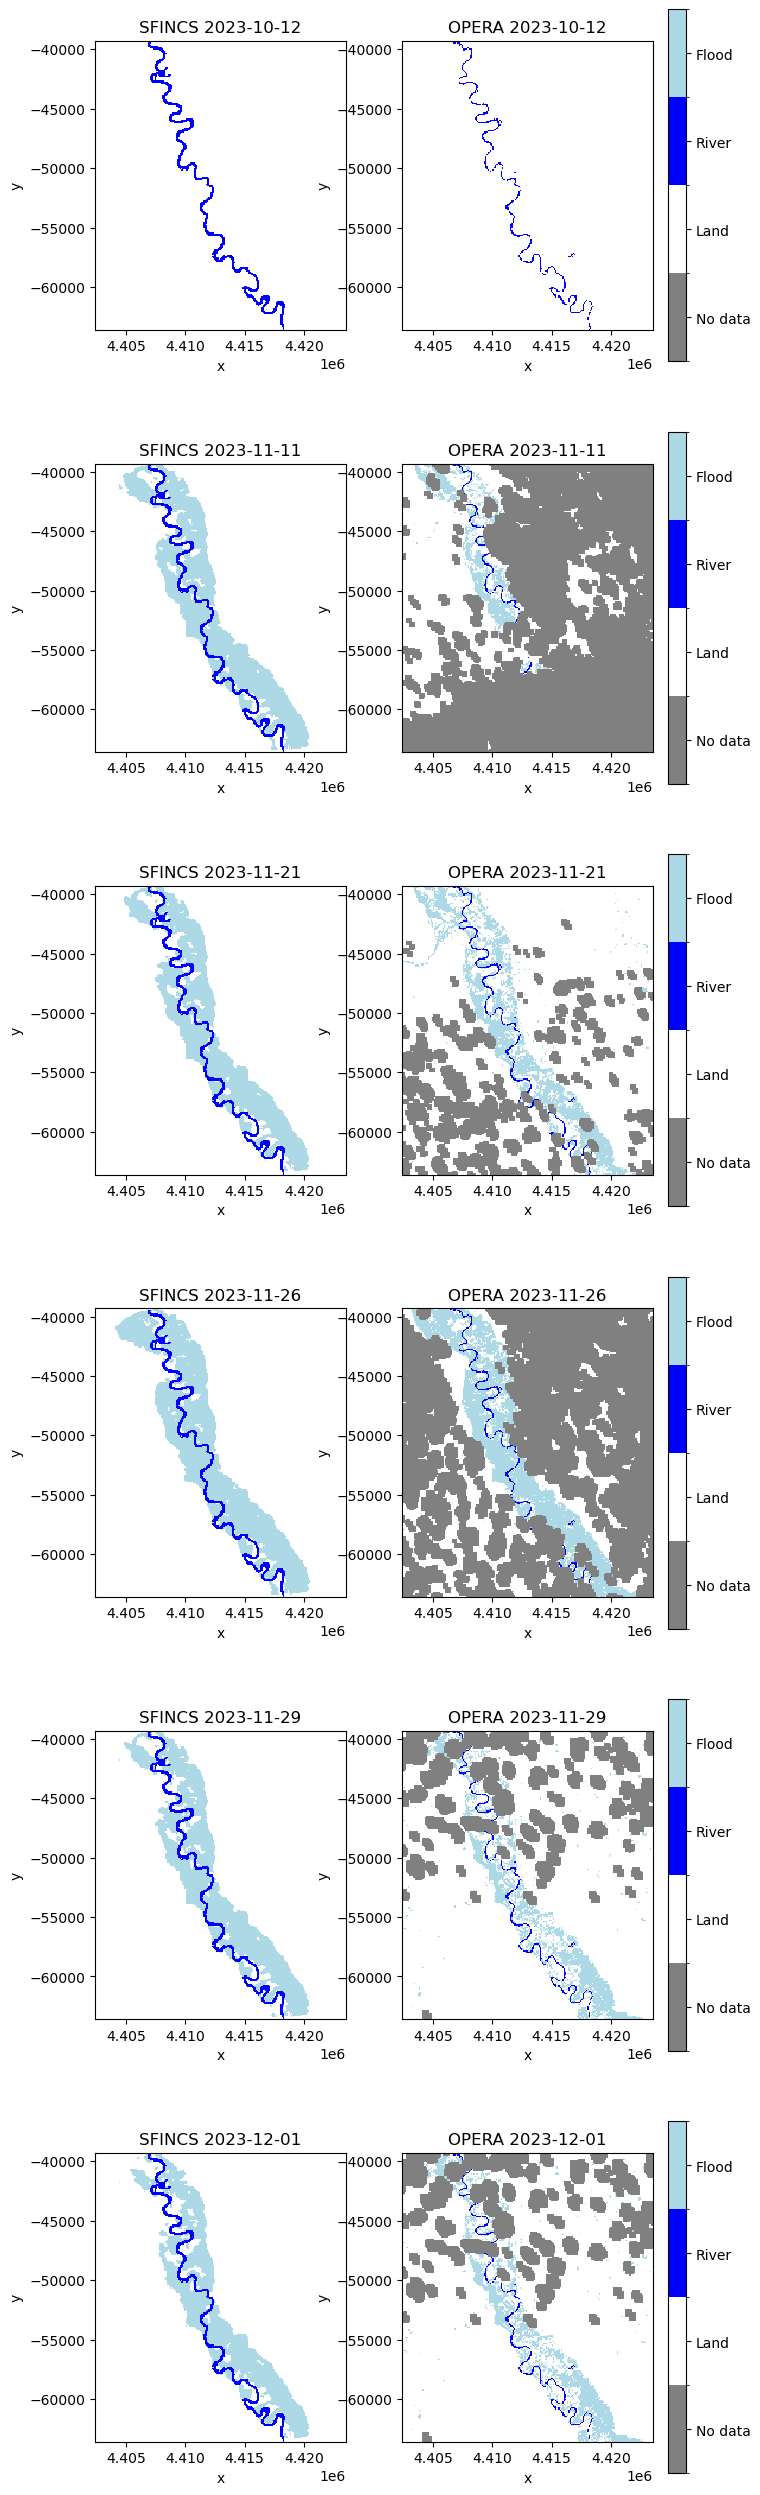

In [13]:
# Example model
print(floodmaps_sfincs_all.keys())
example_model = "garissa_depth2m_fabdem_grid100"
print(example_model)
floodmaps_sfincs = floodmaps_sfincs_all[example_model]

fig, axs = plt.subplots(len(floodmaps_sfincs.values()), 2, figsize=(8, 32),
                        gridspec_kw={'width_ratios': [1, 1.25]})

for i, date in enumerate(floodmaps):
    floodmap = floodmaps[date]

    floodmaps_sfincs[date].plot(ax=axs[i,0], cmap=cmap, norm=norm, add_colorbar=False)
    axs[i, 0].set_title(f"SFINCS {date}")
    axs[i, 0].axis("scaled")

    plot = floodmap.plot(ax=axs[i, 1], cmap=cmap, norm=norm, add_colorbar=False)
    colorbar = plt.colorbar(plot, ax=axs[i, 1])
    colorbar.set_ticks(ticks=[-1, 0, 1, 2], labels=["No data","Land","River","Flood"], minor=False)

    axs[i, 1].set_title(f"OPERA {date}")
    axs[i, 1].axis("scaled")

# plt.tight_layout()

In [14]:
for example_model in model_names:
    floodmaps_sfincs = floodmaps_sfincs_all[example_model]

    fig, axs = plt.subplots(2, len(floodmaps_sfincs.values()) // 2, figsize=(12, 8),)
                            #gridspec_kw={'width_ratios': [1, 1, 1.25]})
    axs = axs.ravel()

    for i, date in enumerate(floodmaps):
        floodmap = floodmaps[date]

        plot = floodmaps_sfincs[date].plot(ax=axs[i], cmap=cmap, norm=norm, add_colorbar=False)
        axs[i].set_title(f"SFINCS {date}")
        axs[i].axis("scaled")

    # Adding colorbar axis on the right
    cbar_ax = fig.add_axes([0.98, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
    colorbar = plt.colorbar(plot, cax=cbar_ax)
    colorbar.set_ticks(ticks=[-1, 0, 1, 2])
    colorbar.set_ticklabels(["No data", "Land", "River", "Flood"])

    plt.tight_layout()
    print(example_model)
    # break
    plt.savefig(Path(f"figs/sfincs_floodmaps/{example_model}.jpg"), bbox_inches="tight")
    plt.close()

garissa_depth2m_fabdem_grid100
garissa_depth2m_fabdem_grid100_avg_buffer5km
garissa_depth2m_fabdem_grid100_avg_lin
garissa_depth2m_srtm30_grid100
garissa_depth3m_fabdem_grid100
garissa_depth4m_fabdem_grid100_avg
garissa_depth4m_srtm30_grid100_avg


Now we define a class to calculate some error statistics.

In [26]:
class Validation:
    def __init__(self, floodmap_sat, floodmap_sfincs):
        
        # True positive
        self.m1b1 = np.sum(((floodmap_sat.data==1) | (floodmap_sat.data==2))
                            & ((floodmap_sfincs.data==1) | (floodmap_sfincs.data==2)))

        # False positive
        self.m1b0 = np.sum(((floodmap_sat.data!=2) & (floodmap_sat.data!=-1) & (floodmap_sat.data!=1))
                           & ((floodmap_sfincs.data==1) | (floodmap_sfincs.data==2)))

        # False negative
        self.m0b1 = np.sum(((floodmap_sat.data==1) | (floodmap_sat.data==2)) 
                           & ((floodmap_sfincs.data!=1) & (floodmap_sfincs.data!=2)))

    def hit_rate(self):
        return self.m1b1 / (self.m1b1 + self.m0b1)
    
    def false_alarm_ratio(self):
        return self.m1b0 / (self.m1b1 + self.m1b0)
    
    def critical_succes_index(self):
        return self.m1b1 / (self.m1b0 + self.m1b0 + self.m1b1)
    
    def error_bias(self):
        return self.m1b0 / self.m0b1
    
    
    @staticmethod
    def compute_metrics(floodmap_sat, floodmap_sfincs):
        val_obj = Validation(floodmap_sat, floodmap_sfincs)
        
        return [float(val_obj.hit_rate()), 
                float(val_obj.false_alarm_ratio()), 
                float(val_obj.critical_succes_index()), 
                float(val_obj.error_bias())]

In [27]:
hit_rates = {}
false_alarm_ratios = {}
critical_succes_indices = {}
error_biases = {}

for model, floodmaps_sfincs in floodmaps_sfincs_all.items():
    hr = []
    far = []
    csi = []
    eb = []
    for date, floodmap_sfincs in floodmaps_sfincs.items():
        floodmap_sat = floodmaps[date]

        error_calc = Validation(floodmap_sat, floodmap_sfincs)
        hr.append(error_calc.hit_rate())
        far.append(error_calc.false_alarm_ratio())
        csi.append(error_calc.critical_succes_index())
        eb.append(error_calc.error_bias())
    
    hit_rates[model] = hr
    false_alarm_ratios[model] = far
    critical_succes_indices[model] = csi
    error_biases[model] = eb

measures = [hit_rates, false_alarm_ratios, critical_succes_indices, error_biases]
measure_titles = ["Hit rate", "False alarm ratio", "Critical succes index", "Error bias"]

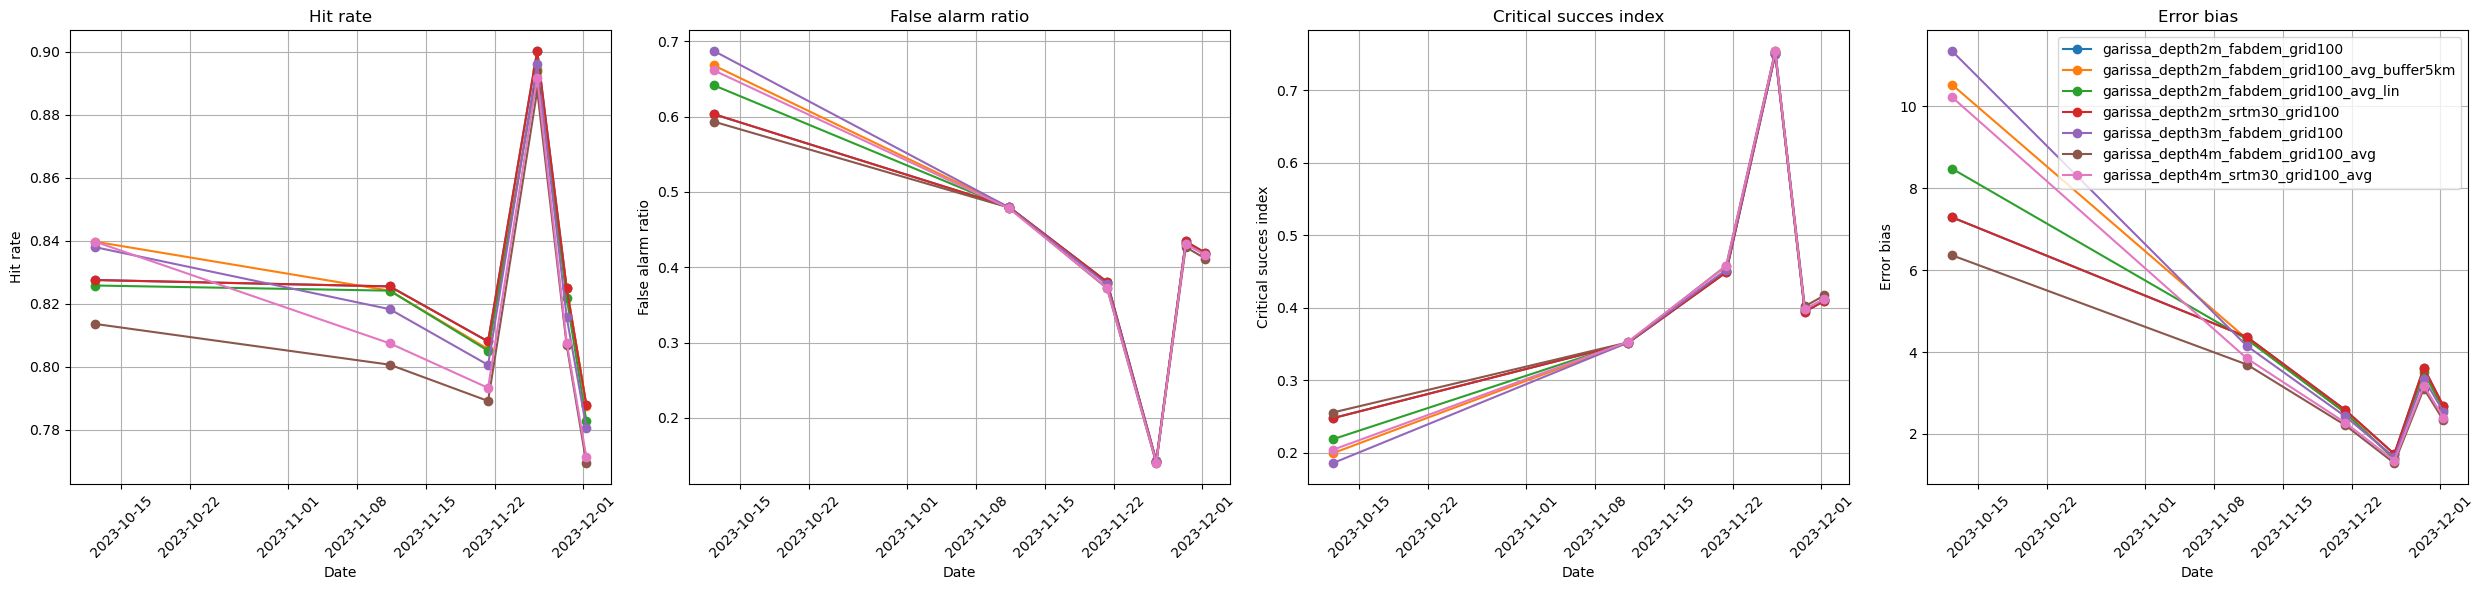

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(25, 6))

for i, ax in enumerate(axs):
    meas = measures[i]

    for model, data in meas.items():
        ax.plot(list(floodmap_times.values()), data, label=model, marker='o')  # Added marker for better visibility
    
    ax.set_xlabel("Date")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel(measure_titles[i])
    ax.set_title(measure_titles[i])
    ax.grid(True)  # Adding grid for better readability
    # ax.legend()  # Placing legends inside each subplot

plt.legend()    
plt.tight_layout()

plt.savefig(Path(r"figs/sfincs_model_scores1.jpg"))

In [18]:
print(model_names)

['garissa_depth2m_fabdem_grid100', 'garissa_depth2m_fabdem_grid100_avg_buffer5km', 'garissa_depth2m_fabdem_grid100_avg_lin', 'garissa_depth2m_srtm30_grid100', 'garissa_depth3m_fabdem_grid100', 'garissa_depth4m_fabdem_grid100_avg', 'garissa_depth4m_srtm30_grid100_avg']
